In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pylab as pl
!pip install sklearn_relief

In [2]:
disease_list = ['Acne and Rosacea Photos',
                'Normal',
                'vitiligo',
                'Tinea Ringworm Candidiasis and other Fungal Infections',
                'Melanoma Skin Cancer Nevi and Moles',
                'Eczema Photos']

In [3]:
path_train="/kaggle/input/skin-dataset/skin_dataset/train/"
train_dictionary={"image_path":[],"target":[]}
k=0
for i in disease_list:
    path_disease_train=path_train+i
    image_list_train=os.listdir(path_disease_train)
    for j in image_list_train:
        img_path_train=path_disease_train+"/"+j
        train_dictionary["image_path"].append(img_path_train)
        train_dictionary['target'].append(k)
    k+=1
train=pd.DataFrame(train_dictionary)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6867 entries, 0 to 6866
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  6867 non-null   object
 1   target      6867 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 107.4+ KB


In [4]:
images = []
label = []
for i in train['image_path']:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(180,180))
    images.append(img)

In [5]:
label = train['target']
print(len(label))
print(len(images))
data = np.array(images)
label = np.array(label)
print(data.shape)
label = keras.utils.to_categorical(label, 6)

6867
6867
(6867, 180, 180, 3)


80134624/80134624 [==============================] - 1s 0us/step


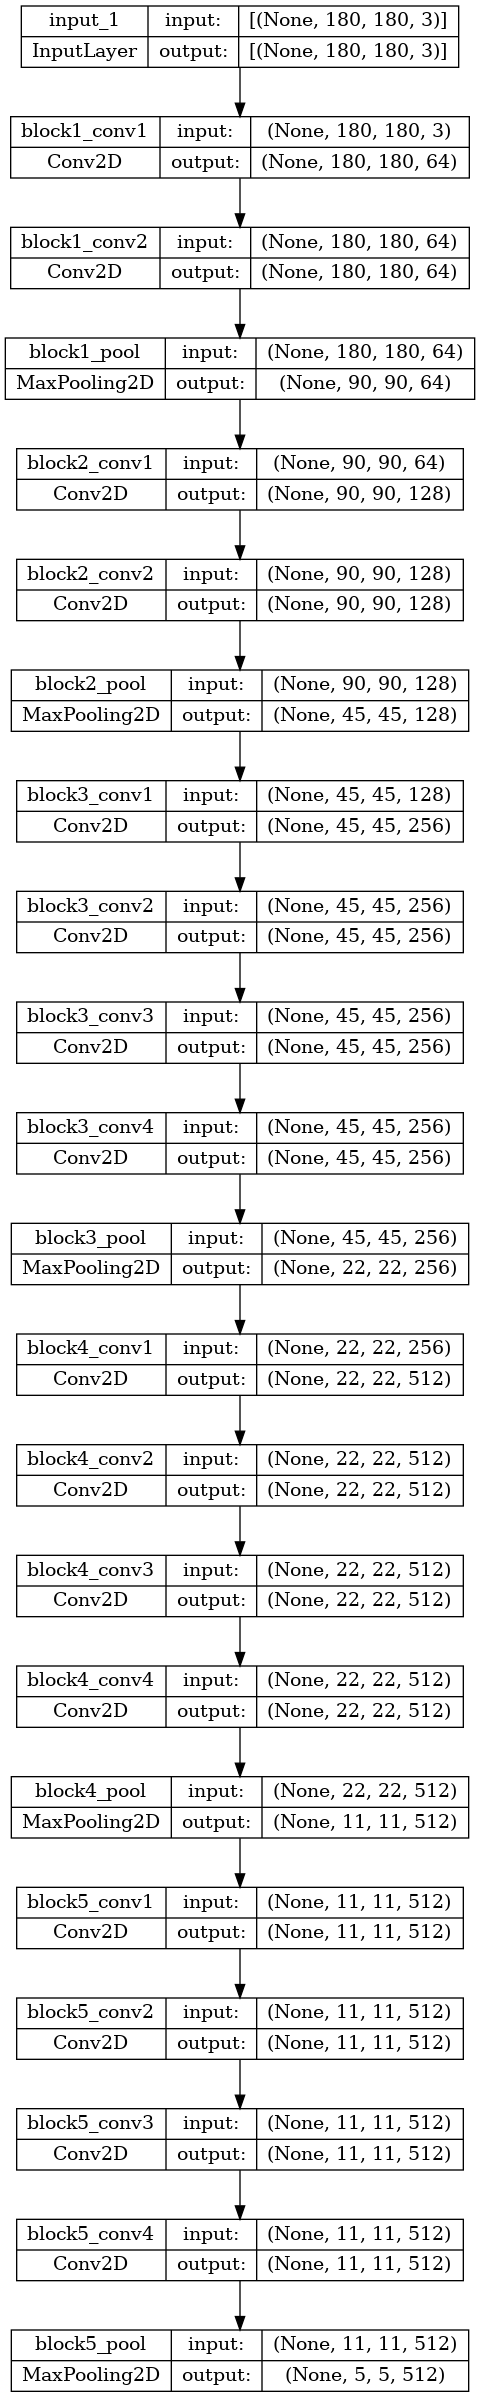

In [6]:
vgg_model = VGG19(weights='imagenet',  include_top=False, input_shape=(180,180,3))
for layer in vgg_model.layers:
    layer.trainable = False
plot_model(vgg_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
model = Sequential([
    Dense(200, activation='relu'),
    Dense(170, activation='relu'),
    Dense(6, activation='softmax')
])
mcp_save = ModelCheckpoint('EnetB0_CIFAR10_TL.h5', save_best_only=True, monitor='val_acc')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
kf = KFold(n_splits=3)

In [8]:
for i in range(3):
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2,random_state=np.random.randint(1,1000,1)[0])
    print(x_train.shape)
    features_train = vgg_model.predict(x_train)
    features_test = vgg_model.predict(x_test)
    print(features_train.shape)
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    x_train=features_train.reshape(num_train,-1)
    x_test=features_test.reshape(num_test,-1)
    print(x_train.shape)

(5493, 180, 180, 3)
43/43 [==============================] - 8s 195ms/step
(5493, 5, 5, 512)
(5493, 12800)
(5493, 180, 180, 3)
43/43 [==============================] - 4s 105ms/step
(5493, 5, 5, 512)
(5493, 12800)
(5493, 180, 180, 3)
43/43 [==============================] - 5s 109ms/step
(5493, 5, 5, 512)
(5493, 12800)


In [9]:
history = model.fit(x_train, y_train, epochs=25)

Epoch 1/25
172/172 [==============================] - 4s 7ms/step - loss: 1.7819 - accuracy: 0.7351
Epoch 2/25
172/172 [==============================] - 1s 4ms/step - loss: 0.4113 - accuracy: 0.8747
Epoch 3/25
172/172 [==============================] - 1s 5ms/step - loss: 0.2013 - accuracy: 0.9359
Epoch 4/25
172/172 [==============================] - 1s 4ms/step - loss: 0.0975 - accuracy: 0.9661
Epoch 5/25
172/172 [==============================] - 1s 4ms/step - loss: 0.0702 - accuracy: 0.9809
Epoch 6/25
172/172 [==============================] - 1s 4ms/step - loss: 0.1165 - accuracy: 0.9701
Epoch 7/25
172/172 [==============================] - 1s 4ms/step - loss: 0.4691 - accuracy: 0.9195
Epoch 8/25
172/172 [==============================] - 1s 4ms/step - loss: 0.2961 - accuracy: 0.9405
Epoch 9/25
172/172 [==============================] - 1s 4ms/step - loss: 0.0933 - accuracy: 0.9751
Epoch 10/25
172/172 [==============================] - 1s 4ms/step - loss: 0.0874 - accuracy: 0.9785

In [10]:
y_pred = model.predict(x_test)
y_pred2 = np.argmax(y_pred, axis=1)
print(y_pred2)
y_test = np.argmax(y_test, axis=1)
print(y_test)

43/43 [==============================] - 0s 3ms/step
[1 4 2 ... 4 3 3]
[1 4 2 ... 4 3 3]


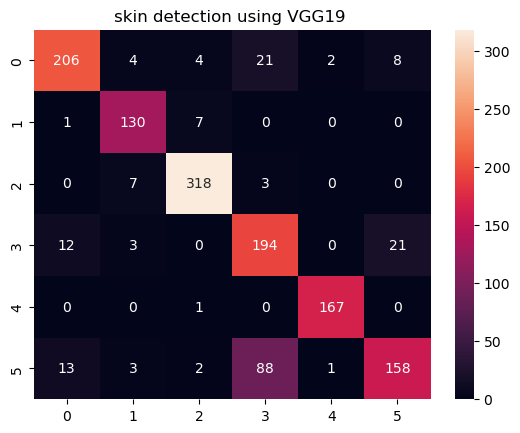

In [11]:
confusion_matrix_result = confusion_matrix(y_test,y_pred2)
plt.title("skin detection using VGG19 ")
ax = plt.subplot()
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', ax=ax);
pl.show()

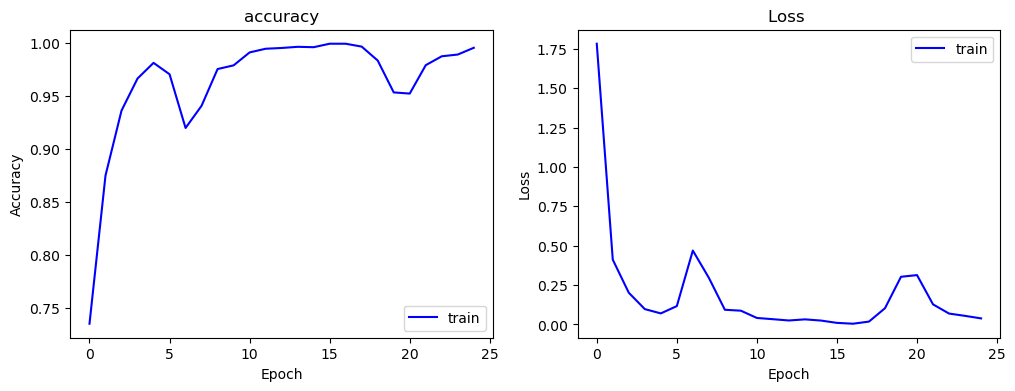

In [12]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

In [13]:
from sklearn.metrics import classification_report
confusion_matrix = classification_report(y_test,y_pred2)
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       245
           1       0.88      0.94      0.91       138
           2       0.96      0.97      0.96       328
           3       0.63      0.84      0.72       230
           4       0.98      0.99      0.99       168
           5       0.84      0.60      0.70       265

    accuracy                           0.85      1374
   macro avg       0.87      0.86      0.86      1374
weighted avg       0.86      0.85      0.85      1374



In [14]:
vgg_model.save('vgg_model.h5')
model.save('model.h5')